In [1]:
import os.path

from u2net import U2NET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from skimage import transform
from umap import UMAP
import datetime
import os
import csv
from skimage.metrics import structural_similarity as ssim

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
all_images_rgb = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        tf_image = tf.expand_dims(image_gray / 255, 2)
    #    tf_rgb = tf.image.grayscale_to_rgb(tf_image)
        tf_preproc = tf.image.resize(tf_image, (1024, 1024))
        all_images_rgb.append(tf_preproc)

all_images_rgb = np.array(all_images_rgb)

In [3]:

image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
net.built=True
net.load_weights('data/saved_models/u2net_loss=0.0089.h5')

model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')

In [8]:

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE_PER_REPLICA = 1
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

with strategy.scope():
    image_shape = (1024, 1024, 1)
    inputs = tf.keras.Input(shape=image_shape)
    net = U2NET(1)
    out = net(inputs)
    net.built=True
    net.load_weights('data/saved_models/u2netP_loss=0.0027.h5')

    model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [14]:
x_train, x_test, y_train, y_test = train_test_split(  all_images_rgb,all_images_rgb, test_size=0.2 )
name=f'u2net_{datetime.datetime.now().date()}'
log_dir=f'data/logs/{name}_tensorboard/'
checkpoint_filepath = f'data/logs/{name}_checkpoint/checkpoints/'
csv_log_filepath= f'data/logs/train_csv/{name}.csv'

In [37]:
optim=tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.1, epsilon=1e-07, centered=True)


if not os.path.exists(csv_log_filepath):
    with open(csv_log_filepath, 'wb') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)



tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_MAE',
    mode='max',
    save_best_only=True)
early_stop_callback=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
csv_logger = tf.keras.callbacks.CSVLogger(csv_log_filepath)

model.compile(optimizer=optim, loss='mse', metrics=['MAE'])
history=model.fit(x_train, y_train,
                  epochs=50,
                  batch_size=2,
                  shuffle=True,
                  validation_data=(x_test, x_test),
                  callbacks=[tensorboard_callback,
                             model_checkpoint_callback,
                             early_stop_callback,
                             csv_logger])

Epoch 1/50
4/4 [==============================] - 14s 1s/step - loss: 0.0059 - MAE: 0.0549 - val_loss: 0.0045 - val_MAE: 0.0422
Epoch 2/50
4/4 [==============================] - 2s 627ms/step - loss: 0.0055 - MAE: 0.0515 - val_loss: 0.0044 - val_MAE: 0.0414
Epoch 3/50
4/4 [==============================] - 2s 629ms/step - loss: 0.0051 - MAE: 0.0477 - val_loss: 0.0044 - val_MAE: 0.0410
Epoch 4/50
4/4 [==============================] - 2s 624ms/step - loss: 0.0050 - MAE: 0.0471 - val_loss: 0.0044 - val_MAE: 0.0408
Epoch 5/50
4/4 [==============================] - 2s 629ms/step - loss: 0.0048 - MAE: 0.0445 - val_loss: 0.0043 - val_MAE: 0.0407
Epoch 6/50
4/4 [==============================] - 3s 647ms/step - loss: 0.0049 - MAE: 0.0451 - val_loss: 0.0044 - val_MAE: 0.0408
Epoch 7/50
4/4 [==============================] - 2s 631ms/step - loss: 0.0047 - MAE: 0.0442 - val_loss: 0.0044 - val_MAE: 0.0409
Epoch 8/50
4/4 [==============================] - 3s 650ms/step - loss: 0.0051 - MAE: 0.0454

KeyboardInterrupt: 

In [34]:
loss=0.0089
net.save_weights(f'u2net_loss={loss}.h5')

In [7]:
image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
# net.built=True
# net.load_weights('data/saved_models/u2net_loss=0.0089.h5')

model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')
model.built=True
model.load_weights('data/logs/u2net_2021-11-18_checkpoint/checkpoints/')


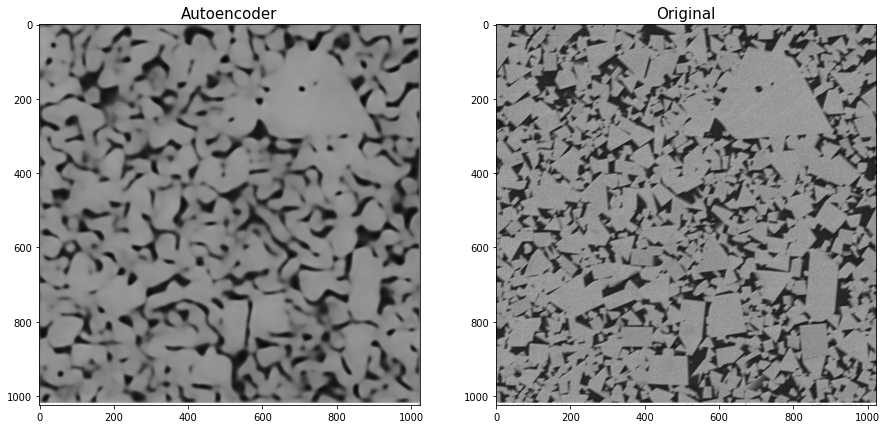

In [30]:
#predict=model.predict(tf.expand_dims(all_images_rgb[0],axis=0))[0]
n=60

predict=net(tf.expand_dims(x_test[n],axis=0))[0][0]

original=x_test[n]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(predict,cmap='gray')
ax1.set_title('Autoencoder',fontsize=15)

ax2.imshow(original,cmap='gray')
ax2.set_title('Original',fontsize=15)
plt.savefig(f'autoencoder{name}.png')
plt.show()

In [14]:
net(tf.expand_dims(all_images_rgb[0],axis=0))[1][0].numpy().shape

(32, 32, 512)

## Visualization

In [4]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
images_embs = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        resized = transform.resize(image_gray, (1024, 1024,1))
        emb=net(tf.expand_dims(resized/255,axis=0))[1][0].numpy().flatten()
        images_embs.append(emb)

In [5]:
umap_1d=UMAP(n_components=1)
umaped_vct_1d=umap_1d.fit_transform(images_embs)


In [14]:
umaped_vct_1d

array([[10.601007 ],
       [ 6.3056717],
       [ 5.781097 ],
       [ 7.7253027],
       [ 5.6888576],
       [ 6.75021  ],
       [ 6.0714636],
       [ 7.527411 ],
       [ 5.7481213],
       [ 6.155268 ],
       [ 6.4462624],
       [ 8.103265 ],
       [10.835751 ],
       [ 7.1092343],
       [ 7.542894 ],
       [ 5.7723737],
       [ 7.7803526],
       [ 6.7850714],
       [ 6.759309 ],
       [ 5.766015 ],
       [ 5.5833097],
       [ 7.7373605],
       [ 5.9578466],
       [ 7.6761827],
       [ 6.4542856],
       [ 6.852649 ],
       [ 6.817015 ],
       [ 5.6437187],
       [ 6.3252454],
       [ 8.133435 ],
       [ 9.150217 ],
       [ 6.423925 ],
       [ 7.9609365],
       [ 8.313675 ],
       [ 8.127515 ],
       [ 6.7896085],
       [ 6.945231 ],
       [ 7.1986732],
       [ 6.7000666],
       [ 6.6053195],
       [ 9.152187 ],
       [ 6.0493364],
       [ 6.7271743],
       [ 8.387218 ],
       [ 5.929827 ],
       [ 6.4433594],
       [ 7.94467  ],
       [ 5.96

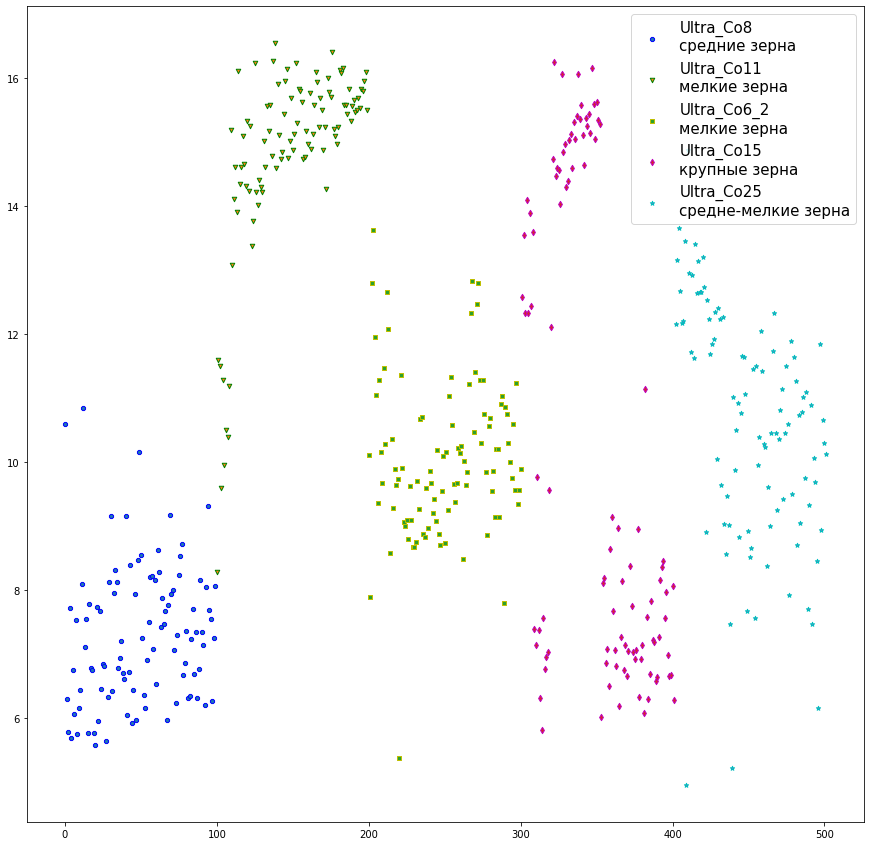

In [15]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors=['b','g','y','m','c']
markers=['8','v','s','d','*',]

for i,images_list in enumerate(all_images):
    start=0
    for j in range(i):
        start+=len(all_images[j])
    end=start+len(images_list)

    ax.scatter(np.arange(start,end),umaped_vct_1d[start:end],edgecolor=colors[i], s=size,marker=markers[i])

ax.legend(names,fontsize=15)
#plt.savefig(f'embs_space_loss={loss}.png')
plt.show()

In [19]:
umap_2d=UMAP()
umaped_vct_2d=umap_2d.fit_transform(images_embs)

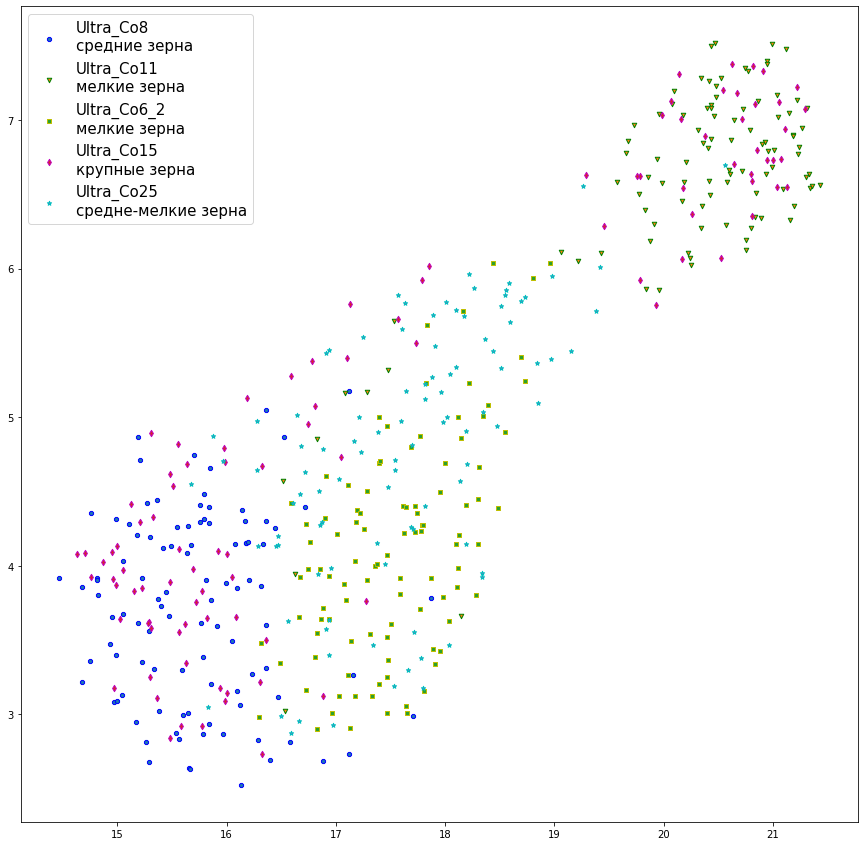

In [20]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors=['b','g','y','m','c']
markers=['8','v','s','d','*',]

for i,images_list in enumerate(all_images):
    start=0
    for j in range(i):
        start+=len(all_images[j])
    end=start+len(images_list)

    ax.scatter(umaped_vct_2d[start:end, 0], umaped_vct_2d[start:end, 1],edgecolor=colors[i], s=size,marker=markers[i])

ax.legend(names,fontsize=15)
#plt.savefig(f'embs_space_loss={loss}.png')
plt.show()

In [19]:
umap_3d = UMAP(n_components=3)
umaped_vct_3d = umap_3d.fit_transform(images_embs)

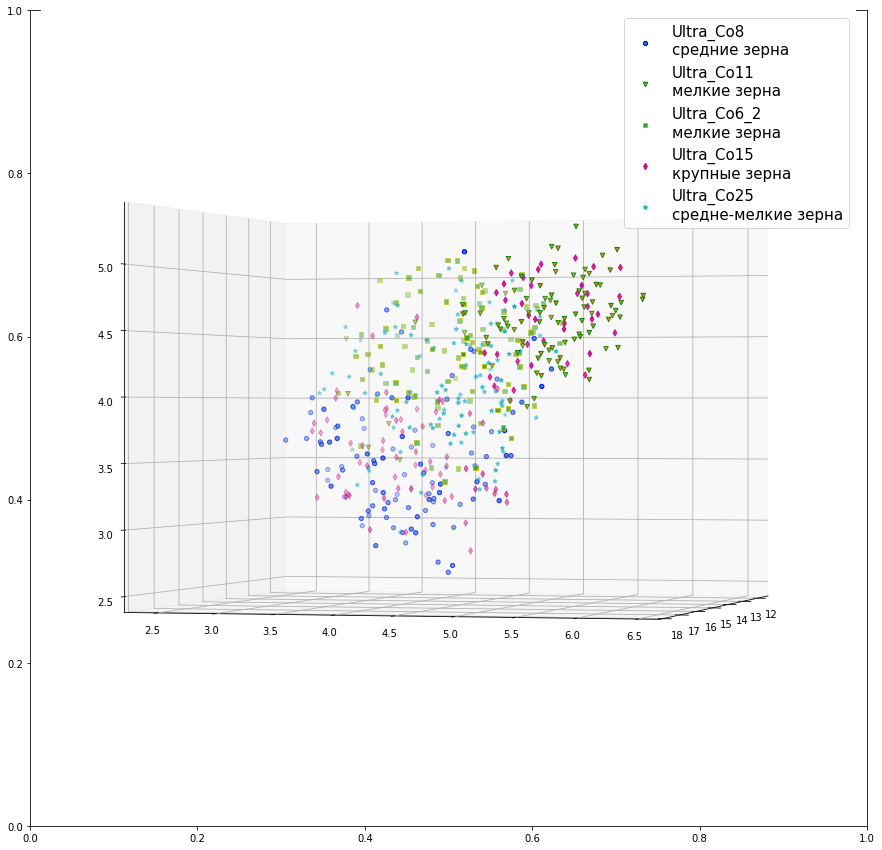

In [33]:
N = 15
fig, ax = plt.subplots(figsize=(N, N))
size = 20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

ax = plt.axes(projection='3d')
for i, images_list in enumerate(all_images):
    start = 0
    for j in range(i):
        start += len(all_images[j])
    end = start + len(images_list)

    ax.scatter3D(umaped_vct_3d[start:end, 0], umaped_vct_3d[start:end, 1],umaped_vct_3d[start:end, 2], edgecolor=colors[i], s=size, marker=markers[i])
  #  ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

ax.legend(names, fontsize=15)
#plt.savefig(f'embs_space_3d_loss={loss}.png')
ax.view_init(0,15)
plt.show()

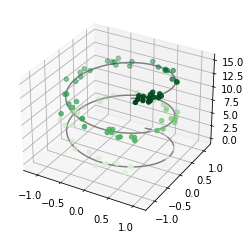

In [18]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');